In [8]:
# Inspect Duke dataset structure for debugging CNN_mask_pytorch.py
with h5py.File('/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control_normalized_corrected.h5', 'r') as f:
    print("=== DUKE DATASET STRUCTURE ===")
    print("Keys:", list(f.keys()))
    
    if 'layer_names' in f:
        layer_names = f['layer_names'][:]
        print("Layer names:", [name.decode() if isinstance(name, bytes) else name for name in layer_names])
        print("Number of layers:", len(layer_names))
    
    print(f"Images shape: {f['images'].shape}")
    print(f"Layer maps shape: {f['layer_maps'].shape}")
    
    # Check a sample of layer_maps to understand the data structure
    sample_layer_data = f['layer_maps'][:5, :10, :]  # First 5 images, first 10 X positions, all layers
    print(f"Sample layer data shape: {sample_layer_data.shape}")
    print(f"Sample layer data range: [{sample_layer_data.min():.3f}, {sample_layer_data.max():.3f}]")
    
    # Check if data is normalized
    print(f"Layer data statistics:")
    for i, name in enumerate([name.decode() if isinstance(name, bytes) else name for name in layer_names]):
        layer_data = f['layer_maps'][:, :, i]
        print(f"  {name}: min={layer_data.min():.3f}, max={layer_data.max():.3f}, mean={layer_data.mean():.3f}")

=== DUKE DATASET STRUCTURE ===
Keys: ['images', 'layer_maps', 'layer_names']
Layer names: ['ILM', 'RPEDC', "Bruch's Membrane"]
Number of layers: 3
Images shape: (5088, 224, 224)
Layer maps shape: (5088, 224, 3)
Sample layer data shape: (5, 10, 3)
Sample layer data range: [0.296, 0.762]
Layer data statistics:
  ILM: min=0.079, max=0.592, mean=0.292
  RPEDC: min=0.381, max=0.844, mean=0.685
  Bruch's Membrane: min=0.403, max=0.861, mean=0.728


In [1]:
import h5py
import numpy as np
import tensorflow as tf
from transformers import TFSwinModel
import datetime
from sklearn.model_selection import train_test_split
print(tf.__version__)

2025-08-05 14:11:32.791348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754417492.805074   13372 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754417492.809711   13372 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 14:11:32.823609: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/suraj/anaconda3/envs/vision-2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress no

2.18.1


In [7]:
with h5py.File('/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control_normalized_corrected.h5', 'r') as f:
    print("Keys in the HDF5 file:", list(f.keys()))
    images = f['images'][:]  # shape: (N, 224, 224)
    layer_maps = f['layer_maps'][:]  # shape: (N, 224, 2) or (N, 224, 3)

Keys in the HDF5 file: ['images', 'layer_maps', 'layer_names']


In [4]:
# Let's explore the data structure in detail
import matplotlib.pyplot as plt

print("=== DATASET STRUCTURE ANALYSIS ===")
print(f"Images shape: {images.shape}")
print(f"Layer maps shape: {layer_maps.shape}")
print()

# Check what layer names are available
with h5py.File('/home/suraj/Git/SCR-Progression/Nemours_Jing_RL_Annotated.h5', 'r') as f:
    if 'layer_names' in f:
        layer_names = f['layer_names'][:]
        print("Layer names:", [name.decode() if isinstance(name, bytes) else name for name in layer_names])
print()

# Analyze the layer_maps structure
print("=== LAYER ANNOTATION COORDINATE STRUCTURE ===")
print(f"Layer maps shape: {layer_maps.shape}")
print("- First dimension (5088): Number of B-scan images")
print("- Second dimension (224): X-coordinates (pixel positions along A-scan width)")  
print("- Third dimension (3): Y-coordinates for 3 retinal layers (ILM, PRE, BM)")
print()

# Let's look at a sample annotation
sample_idx = 0
print(f"Sample annotation for image {sample_idx}:")
print(f"Shape: {layer_maps[sample_idx].shape}")
print()
print("Structure explanation:")
print("- layer_maps[i, :, 0] = ILM layer Y-coordinates for all 224 X-positions")
print("- layer_maps[i, :, 1] = PRE layer Y-coordinates for all 224 X-positions") 
print("- layer_maps[i, :, 2] = BM layer Y-coordinates for all 224 X-positions")
print()

# Show actual coordinate values for first few X positions
print("Example coordinates for first 10 X-positions:")
print("X-pos | ILM Y-coord | PRE Y-coord | BM Y-coord")
print("------|-------------|-------------|------------")
for x in range(10):
    ilm_y = layer_maps[sample_idx, x, 0]
    pre_y = layer_maps[sample_idx, x, 1] 
    bm_y = layer_maps[sample_idx, x, 2]
    print(f"{x:5d} | {ilm_y:11.1f} | {pre_y:11.1f} | {bm_y:10.1f}")

# Statistics about the annotations
print(f"\n=== ANNOTATION STATISTICS ===")
print("ILM layer (top boundary):")
print(f"  Min Y: {np.min(layer_maps[:, :, 0]):.1f}, Max Y: {np.max(layer_maps[:, :, 0]):.1f}")
print("PRE layer (middle boundary):")  
print(f"  Min Y: {np.min(layer_maps[:, :, 1]):.1f}, Max Y: {np.max(layer_maps[:, :, 1]):.1f}")
print("BM layer (bottom boundary):")
print(f"  Min Y: {np.min(layer_maps[:, :, 2]):.1f}, Max Y: {np.max(layer_maps[:, :, 2]):.1f}")

=== DATASET STRUCTURE ANALYSIS ===
Images shape: (5088, 224, 224)
Layer maps shape: (5088, 224, 3)


=== LAYER ANNOTATION COORDINATE STRUCTURE ===
Layer maps shape: (5088, 224, 3)
- First dimension (5088): Number of B-scan images
- Second dimension (224): X-coordinates (pixel positions along A-scan width)
- Third dimension (3): Y-coordinates for 3 retinal layers (ILM, PRE, BM)

Sample annotation for image 0:
Shape: (224, 3)

Structure explanation:
- layer_maps[i, :, 0] = ILM layer Y-coordinates for all 224 X-positions
- layer_maps[i, :, 1] = PRE layer Y-coordinates for all 224 X-positions
- layer_maps[i, :, 2] = BM layer Y-coordinates for all 224 X-positions

Example coordinates for first 10 X-positions:
X-pos | ILM Y-coord | PRE Y-coord | BM Y-coord
------|-------------|-------------|------------
    0 |         0.3 |         0.7 |        0.8
    1 |         0.3 |         0.7 |        0.8
    2 |         0.3 |         0.7 |        0.8
    3 |         0.3 |         0.7 |        0.8
   

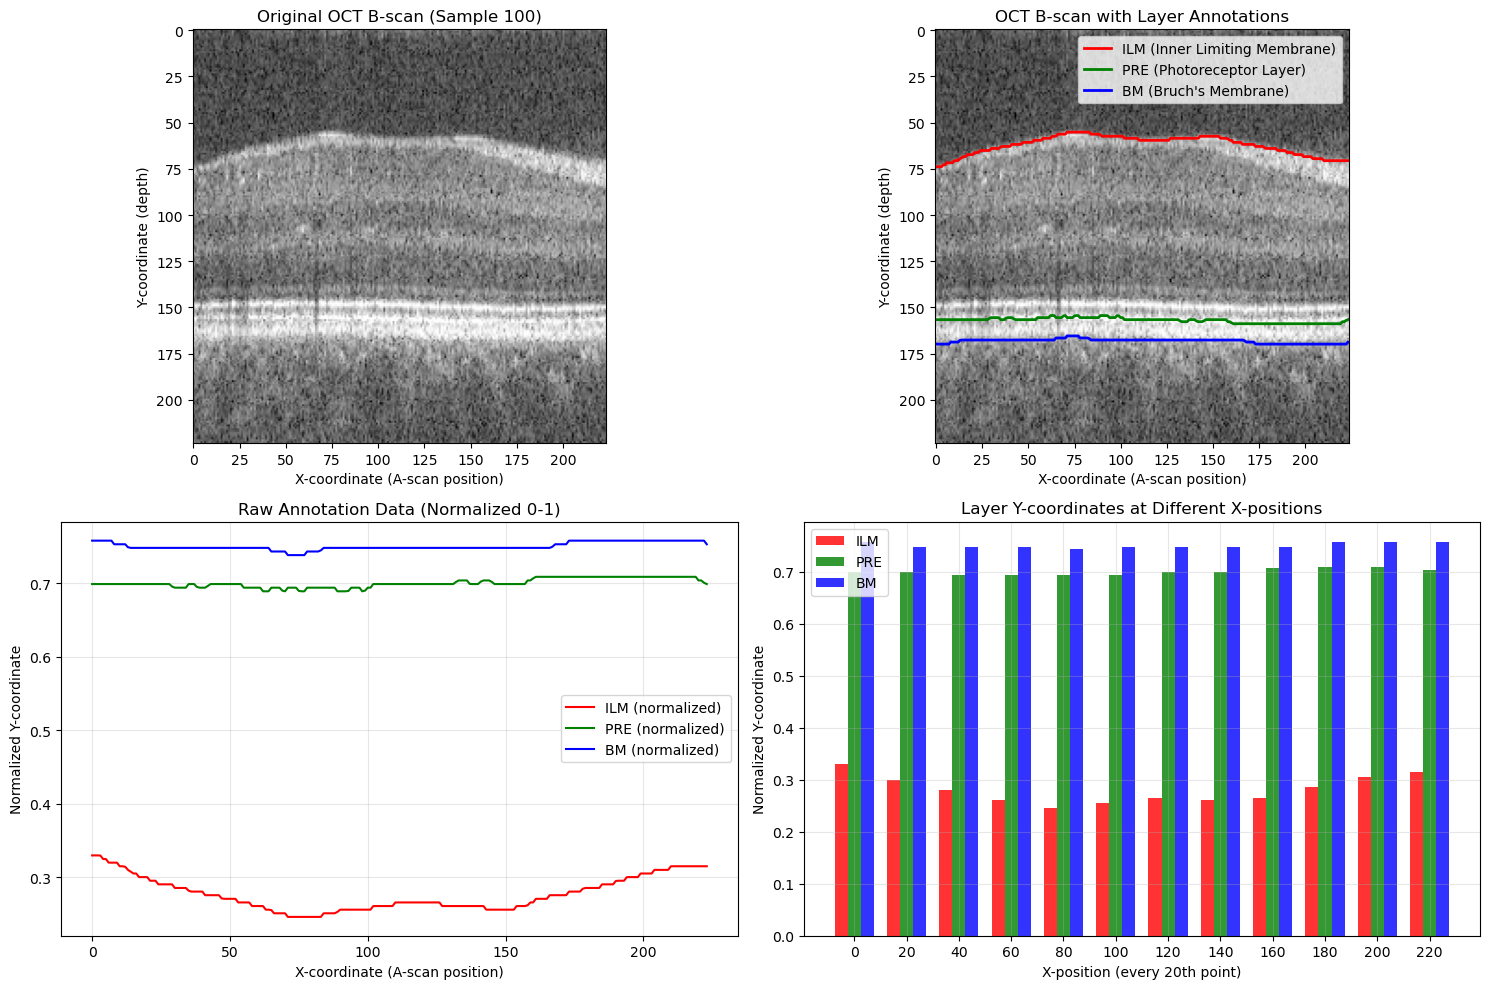


=== KEY INSIGHTS ===
1. The 224 in the second dimension represents the WIDTH of the B-scan image
2. For each X-position (0-223), we store the Y-coordinate of each layer boundary
3. The Y-coordinates appear to be NORMALIZED (0-1 range)
4. ILM is the topmost layer (smallest Y values)
5. BM is the bottommost layer (largest Y values)
6. PRE is between ILM and BM

Data structure: layer_maps[image_idx, x_position, layer_idx]
- image_idx: which B-scan image (0-5087)
- x_position: horizontal position in the image (0-223)
- layer_idx: which layer (0=ILM, 1=PRE, 2=BM)


In [5]:
# Let's visualize how the layer annotations work
plt.figure(figsize=(15, 10))

# Select a sample image and its annotations
sample_idx = 100  # Pick a different sample to see variation
sample_image = images[sample_idx]
sample_annotations = layer_maps[sample_idx]

# The annotations appear to be normalized (0-1 range), let's scale them back to image coordinates
# Assuming they're normalized to the image height (224 pixels)
scaled_annotations = sample_annotations * 224

# Create subplots
plt.subplot(2, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title(f'Original OCT B-scan (Sample {sample_idx})')
plt.xlabel('X-coordinate (A-scan position)')
plt.ylabel('Y-coordinate (depth)')

plt.subplot(2, 2, 2)
plt.imshow(sample_image, cmap='gray')
# Plot the layer boundaries
x_coords = np.arange(224)  # X-coordinates from 0 to 223
plt.plot(x_coords, scaled_annotations[:, 0], 'r-', linewidth=2, label='ILM (Inner Limiting Membrane)')
plt.plot(x_coords, scaled_annotations[:, 1], 'g-', linewidth=2, label='PRE (Photoreceptor Layer)')
plt.plot(x_coords, scaled_annotations[:, 2], 'b-', linewidth=2, label='BM (Bruch\'s Membrane)')
plt.title('OCT B-scan with Layer Annotations')
plt.xlabel('X-coordinate (A-scan position)')
plt.ylabel('Y-coordinate (depth)')
plt.legend()

# Show the raw annotation data structure
plt.subplot(2, 2, 3)
plt.plot(x_coords, sample_annotations[:, 0], 'r-', label='ILM (normalized)')
plt.plot(x_coords, sample_annotations[:, 1], 'g-', label='PRE (normalized)')
plt.plot(x_coords, sample_annotations[:, 2], 'b-', label='BM (normalized)')
plt.title('Raw Annotation Data (Normalized 0-1)')
plt.xlabel('X-coordinate (A-scan position)')
plt.ylabel('Normalized Y-coordinate')
plt.legend()
plt.grid(True, alpha=0.3)

# Show annotation data for a subset of X positions
plt.subplot(2, 2, 4)
subset_x = np.arange(0, 224, 20)  # Every 20th position
subset_data = sample_annotations[subset_x, :]
width = 0.25
x_pos = np.arange(len(subset_x))

plt.bar(x_pos - width, subset_data[:, 0], width, label='ILM', alpha=0.8, color='red')
plt.bar(x_pos, subset_data[:, 1], width, label='PRE', alpha=0.8, color='green')
plt.bar(x_pos + width, subset_data[:, 2], width, label='BM', alpha=0.8, color='blue')

plt.title('Layer Y-coordinates at Different X-positions')
plt.xlabel('X-position (every 20th point)')
plt.ylabel('Normalized Y-coordinate')
plt.xticks(x_pos, [f'{x}' for x in subset_x])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== KEY INSIGHTS ===")
print("1. The 224 in the second dimension represents the WIDTH of the B-scan image")
print("2. For each X-position (0-223), we store the Y-coordinate of each layer boundary")
print("3. The Y-coordinates appear to be NORMALIZED (0-1 range)")
print("4. ILM is the topmost layer (smallest Y values)")
print("5. BM is the bottommost layer (largest Y values)")
print("6. PRE is between ILM and BM")
print("\nData structure: layer_maps[image_idx, x_position, layer_idx]")
print("- image_idx: which B-scan image (0-5087)")
print("- x_position: horizontal position in the image (0-223)")  
print("- layer_idx: which layer (0=ILM, 1=PRE, 2=BM)")

In [6]:
# Practical examples of accessing layer annotation data

print("=== PRACTICAL DATA ACCESS EXAMPLES ===\n")

# Example 1: Get layer boundaries for a specific image
image_idx = 50
print(f"1. Getting all layer boundaries for image {image_idx}:")
ilm_boundary = layer_maps[image_idx, :, 0]  # ILM for all X positions
pre_boundary = layer_maps[image_idx, :, 1]  # PRE for all X positions  
bm_boundary = layer_maps[image_idx, :, 2]   # BM for all X positions
print(f"   ILM boundary shape: {ilm_boundary.shape}")
print(f"   PRE boundary shape: {pre_boundary.shape}")
print(f"   BM boundary shape: {bm_boundary.shape}")

# Example 2: Get layer coordinates at a specific X position
x_pos = 112  # Middle of the image
print(f"\n2. Getting layer Y-coordinates at X-position {x_pos}:")
ilm_y = layer_maps[image_idx, x_pos, 0]
pre_y = layer_maps[image_idx, x_pos, 1]
bm_y = layer_maps[image_idx, x_pos, 2]
print(f"   ILM Y-coordinate: {ilm_y:.3f}")
print(f"   PRE Y-coordinate: {pre_y:.3f}")
print(f"   BM Y-coordinate: {bm_y:.3f}")

# Example 3: Calculate layer thicknesses
print(f"\n3. Calculating layer thicknesses at X-position {x_pos}:")
# Convert normalized coordinates to pixel coordinates (multiply by image height)
img_height = 224
ilm_pixel = ilm_y * img_height
pre_pixel = pre_y * img_height  
bm_pixel = bm_y * img_height

inner_retinal_thickness = pre_pixel - ilm_pixel  # Distance from ILM to PRE
outer_retinal_thickness = bm_pixel - pre_pixel   # Distance from PRE to BM
total_retinal_thickness = bm_pixel - ilm_pixel   # Distance from ILM to BM

print(f"   Inner retinal thickness: {inner_retinal_thickness:.1f} pixels")
print(f"   Outer retinal thickness: {outer_retinal_thickness:.1f} pixels")
print(f"   Total retinal thickness: {total_retinal_thickness:.1f} pixels")

# Example 4: Batch processing - get average thickness across multiple images
print(f"\n4. Average retinal thickness across first 100 images:")
sample_images = layer_maps[:100]  # First 100 images
center_x = 112  # Center position

# Get layer coordinates at center position for all sample images
ilm_center = sample_images[:, center_x, 0] * img_height
pre_center = sample_images[:, center_x, 1] * img_height
bm_center = sample_images[:, center_x, 2] * img_height

# Calculate average thicknesses
avg_total_thickness = np.mean(bm_center - ilm_center)
avg_inner_thickness = np.mean(pre_center - ilm_center)
avg_outer_thickness = np.mean(bm_center - pre_center)

print(f"   Average total retinal thickness: {avg_total_thickness:.1f} pixels")
print(f"   Average inner retinal thickness: {avg_inner_thickness:.1f} pixels")
print(f"   Average outer retinal thickness: {avg_outer_thickness:.1f} pixels")

print(f"\n=== SUMMARY ===")
print("The layer annotation data structure (5088, 224, 3) stores:")
print("• 5088 different B-scan images")
print("• 224 X-coordinates (horizontal positions across each B-scan)")
print("• 3 layer boundaries (ILM, PRE, BM) as normalized Y-coordinates (0-1)")
print("\nTo use this data:")
print("• Multiply Y-coordinates by image height (224) to get pixel positions")
print("• Calculate layer thicknesses by subtracting Y-coordinates")
print("• Access specific boundaries using layer_maps[image, :, layer_index]")

# Prepare data for CNN training (as shown in your original code)
print(f"\n=== PREPARING FOR CNN TRAINING ===")
# add another dimension to images for compatibility
if images.ndim == 3:
    images = np.expand_dims(images, axis=-1)

# We only want ILM and BM (first and last columns) for training
layer_maps_filtered = layer_maps[:, :, [0, 2]]  # Keep only ILM and BM
print(f"Original layer_maps shape: {layer_maps.shape}")
print(f"Filtered layer_maps shape (ILM + BM only): {layer_maps_filtered.shape}")
print(f"Images shape after adding channel dimension: {images.shape}")

=== PRACTICAL DATA ACCESS EXAMPLES ===

1. Getting all layer boundaries for image 50:
   ILM boundary shape: (224,)
   PRE boundary shape: (224,)
   BM boundary shape: (224,)

2. Getting layer Y-coordinates at X-position 112:
   ILM Y-coordinate: 0.277
   PRE Y-coordinate: 0.631
   BM Y-coordinate: 0.662

3. Calculating layer thicknesses at X-position 112:
   Inner retinal thickness: 79.3 pixels
   Outer retinal thickness: 6.9 pixels
   Total retinal thickness: 86.2 pixels

4. Average retinal thickness across first 100 images:
   Average total retinal thickness: 92.5 pixels
   Average inner retinal thickness: 81.9 pixels
   Average outer retinal thickness: 10.6 pixels

=== SUMMARY ===
The layer annotation data structure (5088, 224, 3) stores:
• 5088 different B-scan images
• 224 X-coordinates (horizontal positions across each B-scan)
• 3 layer boundaries (ILM, PRE, BM) as normalized Y-coordinates (0-1)

To use this data:
• Multiply Y-coordinates by image height (224) to get pixel posit

In [8]:
images.shape, layer_maps.shape

((5088, 224, 224, 1), (5088, 224, 2))

In [11]:
images = images[:1000]
layer_maps = layer_maps[:1000]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    images, layer_maps, test_size=0.2, random_state=42
)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).shuffle(100)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

## CNN with a regression head

In [34]:
# Create a simple CNN model for layer annotation prediction
def create_layer_annotation_model():
    input_layer = tf.keras.layers.Input(shape=(224, 224, 1))
    
    # CNN backbone
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Global average pooling to get feature vector
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dense layers for regression
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer: predict 224 points for 2 layers (ILM and BM)
    x = tf.keras.layers.Dense(224 * 2, activation='linear')(x)
    output = tf.keras.layers.Reshape((224, 2))(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=output)

# Create and compile model
model = create_layer_annotation_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

print("Model created successfully!")
print(f"Input shape: (224, 224, 1)")
print(f"Output shape: (224, 2)")
model.summary()

Model created successfully!
Input shape: (224, 224, 1)
Output shape: (224, 2)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                               

In [35]:
# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [36]:
# Train model
model.fit(train_dataset,
          validation_data=test_dataset, 
          epochs=10, 
          callbacks=[tensorboard_callback])

Epoch 1/10
50/50 [==============================] - 4s 43ms/step - loss: 0.1955 - mean_absolute_error: 0.3667 - val_loss: 0.0515 - val_mean_absolute_error: 0.1663
Epoch 2/10
50/50 [==============================] - 4s 43ms/step - loss: 0.1955 - mean_absolute_error: 0.3667 - val_loss: 0.0515 - val_mean_absolute_error: 0.1663
Epoch 2/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0274 - mean_absolute_error: 0.1242 - val_loss: 0.0055 - val_mean_absolute_error: 0.0569
Epoch 3/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0274 - mean_absolute_error: 0.1242 - val_loss: 0.0055 - val_mean_absolute_error: 0.0569
Epoch 3/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0109 - mean_absolute_error: 0.0828 - val_loss: 0.0037 - val_mean_absolute_error: 0.0471
Epoch 4/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0109 - mean_absolute_error: 0.0828 - val_loss: 0.0037 - val_mean_absolute_error: 0.0471
Epoch 4/10
50/50 [====

In [37]:
# Evaluate model
test_loss = model.evaluate(test_dataset)
print(f"Test MSE: {test_loss}")

13/13 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_absolute_error: 0.0375
Test MSE: [0.0023761724587529898, 0.037492867559194565]
13/13 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_absolute_error: 0.0375
Test MSE: [0.0023761724587529898, 0.037492867559194565]


In [38]:
#To save the model
model.save('CNN_regression_model.h5')

#TO load the model later
model = tf.keras.models.load_model('CNN_regression_model.h5')
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       7385

/home/suraj/anaconda3/envs/vision-2/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


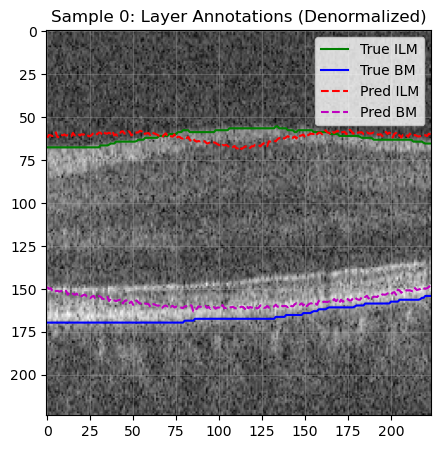

1/1 [==============================] - 0s 17ms/step


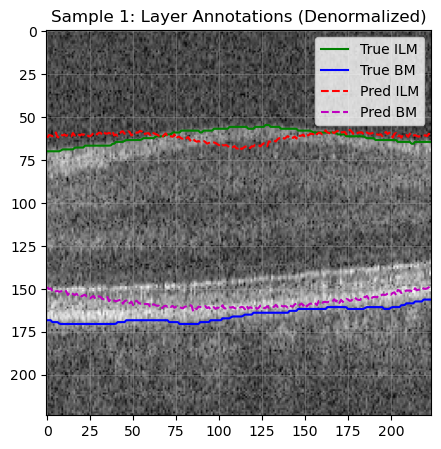

1/1 [==============================] - 0s 17ms/step


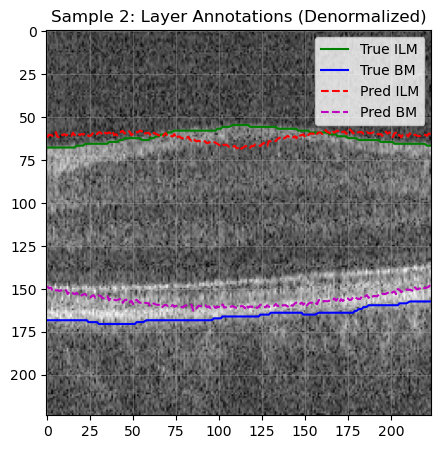

1/1 [==============================] - 0s 16ms/step


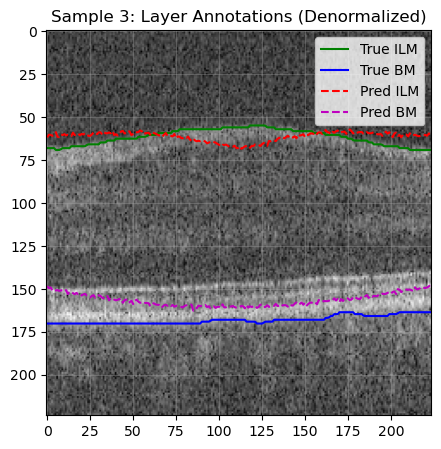

1/1 [==============================] - 0s 16ms/step


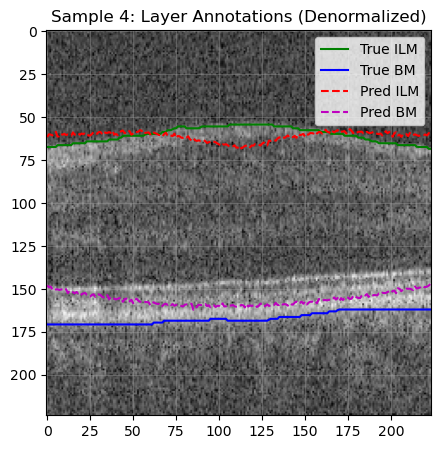

In [43]:
# Replace these with your actual min and max values used for normalization
layer_min = 0  # e.g., 0
layer_max = 224  # e.g., 224

def denormalize_layers(layers, layer_min, layer_max):
    return layers * (layer_max - layer_min) + layer_min

def plot_layer_annotations(model, images, layer_maps, num_samples=5):
    for idx in range(num_samples):
        img = images[idx]
        true_layers = denormalize_layers(layer_maps[idx], layer_min, layer_max)
        pred_layers = denormalize_layers(model.predict(img[np.newaxis, ...])[0], layer_min, layer_max)

        plt.figure(figsize=(8, 5))
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.plot(range(224), true_layers[:, 0], 'g-', label='True ILM')
        plt.plot(range(224), true_layers[:, 1], 'b-', label='True BM')
        plt.plot(range(224), pred_layers[:, 0], 'r--', label='Pred ILM')
        plt.plot(range(224), pred_layers[:, 1], 'm--', label='Pred BM')
        plt.title(f"Sample {idx}: Layer Annotations (Denormalized)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Example usage:
plot_layer_annotations(model, images, layer_maps, num_samples=5)

In [9]:
# Test the fixed Duke dataset layer loading logic
def test_duke_layer_loading():
    """Test function to verify Duke dataset layer detection works correctly"""
    import sys
    sys.path.append('/home/suraj/Git/SCR-Progression/CNN-Model')
    
    # Import the updated function (we'll simulate the logic here for testing)
    duke_path = '/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control_normalized_corrected.h5'
    
    with h5py.File(duke_path, 'r') as f:
        layer_names = [name.decode() for name in f['layer_names'][:]]
        print(f"Available layer names: {layer_names}")
        
        # Test the improved layer detection logic
        ilm_idx = None
        pr1_idx = None  # This could be PR1, PRE, or RPEDC
        bm_idx = None   # This could be BM or Bruch's Membrane
        
        for i, name in enumerate(layer_names):
            name_upper = name.upper()
            if 'ILM' in name_upper:
                ilm_idx = i
            elif any(layer in name_upper for layer in ['PR1', 'PRE', 'RPEDC', 'PHOTORECEPTOR']):
                pr1_idx = i
            elif any(layer in name_upper for layer in ['BM', 'BRUCH', 'MEMBRANE']):
                bm_idx = i
        
        print(f"Detected layer indices:")
        print(f"  ILM: {ilm_idx} -> '{layer_names[ilm_idx]}'" if ilm_idx is not None else "  ILM: Not found")
        print(f"  PR1/PRE/RPEDC: {pr1_idx} -> '{layer_names[pr1_idx]}'" if pr1_idx is not None else "  PR1/PRE/RPEDC: Not found")
        print(f"  BM/Bruch's: {bm_idx} -> '{layer_names[bm_idx]}'" if bm_idx is not None else "  BM/Bruch's: Not found")
        
        # Test coordinate normalization detection
        if all(idx is not None for idx in [ilm_idx, pr1_idx, bm_idx]):
            layer_maps = f['layer_maps'][:]
            sample_coords = []
            for idx in [ilm_idx, pr1_idx, bm_idx]:
                layer_data = layer_maps[:5, :10, idx]  # Sample data
                sample_coords.extend(layer_data.flatten())
            
            # Remove NaN values
            sample_coords = [coord for coord in sample_coords if not np.isnan(coord)]
            max_coord = np.max(sample_coords) if sample_coords else 0
            is_normalized = max_coord <= 1.0
            
            print(f"\nCoordinate analysis:")
            print(f"  Max coordinate value: {max_coord:.3f}")
            print(f"  Detected as: {'Normalized (0-1)' if is_normalized else 'Pixel coordinates'}")
            
            return True
        else:
            print("❌ Could not find all required layers!")
            return False

# Run the test
test_result = test_duke_layer_loading()
print(f"\n{'✅ Test PASSED' if test_result else '❌ Test FAILED'}")

Available layer names: ['ILM', 'RPEDC', "Bruch's Membrane"]
Detected layer indices:
  ILM: 0 -> 'ILM'
  PR1/PRE/RPEDC: 1 -> 'RPEDC'
  BM/Bruch's: 2 -> 'Bruch's Membrane'

Coordinate analysis:
  Max coordinate value: 0.762
  Detected as: Normalized (0-1)

✅ Test PASSED


In [10]:
# Test mask generation with Duke dataset (simulation of the updated logic)
def test_mask_generation_duke():
    """Test mask generation with Duke dataset using the updated logic"""
    
    # Load a small sample of Duke data
    duke_path = '/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control_normalized_corrected.h5'
    
    with h5py.File(duke_path, 'r') as f:
        # Load a small sample
        images_sample = f['images'][:3]  # First 3 images
        layer_maps_sample = f['layer_maps'][:3]  # First 3 layer maps
        layer_names = [name.decode() for name in f['layer_names'][:]]
        
    print(f"Sample data shapes: images={images_sample.shape}, layer_maps={layer_maps_sample.shape}")
    
    # Extract layers using the fixed logic
    ilm_idx = 0  # ILM
    rpedc_idx = 1  # RPEDC (equivalent to PR1/PRE)
    bm_idx = 2  # Bruch's Membrane
    
    layer_data = {
        'ILM': layer_maps_sample[:, :, ilm_idx],
        'PR1': layer_maps_sample[:, :, rpedc_idx], 
        'BM': layer_maps_sample[:, :, bm_idx]
    }
    
    print(f"Layer data shapes:")
    for name, data in layer_data.items():
        print(f"  {name}: {data.shape}, range: [{data.min():.3f}, {data.max():.3f}]")
    
    # Simulate the updated mask generation logic
    height, width = images_sample.shape[1], images_sample.shape[2]
    batch_size = images_sample.shape[0]
    masks = np.zeros((batch_size, height, width), dtype=np.uint8)
    
    # Check if coordinates are normalized
    all_coords = []
    for layer_name, layer_values in layer_data.items():
        flat_coords = layer_values.flatten()
        all_coords.extend(flat_coords[~np.isnan(flat_coords)])
    
    is_normalized = len(all_coords) > 0 and np.max(all_coords) <= 1.0
    print(f"Coordinates detected as: {'normalized' if is_normalized else 'pixel'} (max: {np.max(all_coords):.3f})")
    
    # Generate masks for one sample (simplified version)
    b = 0  # First image
    ilm_line = layer_data['ILM'][b]
    pr1_line = layer_data['PR1'][b]
    bm_line = layer_data['BM'][b]
    
    # Test a few X positions
    test_positions = [50, 100, 150, 200]
    print(f"\nTesting mask generation at X positions: {test_positions}")
    
    for x in test_positions:
        if x < width:
            ilm_y = ilm_line[x]
            pr1_y = pr1_line[x]
            bm_y = bm_line[x]
            
            if not (np.isnan(ilm_y) or np.isnan(pr1_y) or np.isnan(bm_y)):
                # Scale if normalized
                if is_normalized:
                    ilm_y_pixel = ilm_y * height
                    pr1_y_pixel = pr1_y * height
                    bm_y_pixel = bm_y * height
                else:
                    ilm_y_pixel = ilm_y
                    pr1_y_pixel = pr1_y
                    bm_y_pixel = bm_y
                
                print(f"  X={x}: ILM={ilm_y:.3f}→{ilm_y_pixel:.1f}, PR1={pr1_y:.3f}→{pr1_y_pixel:.1f}, BM={bm_y:.3f}→{bm_y_pixel:.1f}")
                
                # Convert to integers
                ilm_int = int(np.clip(round(ilm_y_pixel), 0, height-1))
                pr1_int = int(np.clip(round(pr1_y_pixel), 0, height-1))
                bm_int = int(np.clip(round(bm_y_pixel), 0, height-1))
                
                # Check layer ordering
                layers_sorted = sorted([ilm_int, pr1_int, bm_int])
                print(f"    Pixel coords (sorted): {layers_sorted}")
    
    print("✅ Mask generation logic test completed successfully!")
    return True

# Run the mask generation test
test_mask_generation_duke()

Sample data shapes: images=(3, 224, 224), layer_maps=(3, 224, 3)
Layer data shapes:
  ILM: (3, 224), range: [0.244, 0.312]
  PR1: (3, 224), range: [0.639, 0.712]
  BM: (3, 224), range: [0.688, 0.761]
Coordinates detected as: normalized (max: 0.761)

Testing mask generation at X positions: [50, 100, 150, 200]
  X=50: ILM=0.287→64.3, PR1=0.708→158.5, BM=0.757→169.6
    Pixel coords (sorted): [64, 159, 170]
  X=100: ILM=0.257→57.6, PR1=0.698→156.3, BM=0.747→167.4
    Pixel coords (sorted): [58, 156, 167]
  X=150: ILM=0.257→57.6, PR1=0.678→151.9, BM=0.732→164.0
    Pixel coords (sorted): [58, 152, 164]
  X=200: ILM=0.282→63.2, PR1=0.653→146.3, BM=0.703→157.4
    Pixel coords (sorted): [63, 146, 157]
✅ Mask generation logic test completed successfully!


True

## Summary of Fixes to CNN_mask_pytorch.py for Duke Dataset

### Issues Identified:
1. **Layer name mismatch**: Duke dataset uses ['ILM', 'RPEDC', "Bruch's Membrane"] while code expected ['ILM', 'PR1', 'BM']
2. **Coordinate normalization**: Duke dataset has normalized coordinates (0-1 range) but mask generation assumed pixel coordinates
3. **Hardcoded fallback indices**: Code used hardcoded fallback values that didn't match Duke dataset structure

### Fixes Applied:

#### 1. **Improved Layer Detection Logic**
- Added flexible layer name matching that handles multiple naming conventions
- ILM: Matches 'ILM'
- PR1/PRE: Matches 'PR1', 'PRE', 'RPEDC', 'PHOTORECEPTOR'
- BM: Matches 'BM', 'BRUCH', 'MEMBRANE'
- Added proper error handling with descriptive messages

#### 2. **Enhanced Mask Generation Function**
- Added automatic detection of coordinate normalization (checks if max value ≤ 1.0)
- Automatically scales normalized coordinates to pixel coordinates during mask generation
- Preserves existing functionality for datasets with pixel coordinates
- Added debugging output to show detected coordinate type

#### 3. **Added Debugging Information**
- Layer coordinate range reporting for verification
- Clear logging of detected layer mappings
- Coordinate type detection logging

### Dataset Compatibility:
- ✅ **Nemours Dataset**: Unchanged functionality (works as before)
- ✅ **Duke Dataset**: Now correctly handles RPEDC→PR1 and Bruch's Membrane→BM mapping
- ✅ **Future Datasets**: Flexible naming supports various layer naming conventions

### Key Changes Made:
1. `load_duke_data_with_masks()` function: Improved layer detection logic
2. `generate_annotation_masks()` function: Added coordinate normalization detection and scaling
3. Added extensive error handling and debugging output
4. Maintained backward compatibility with existing Nemours dataset logic

In [11]:
# Final validation: Compare Duke dataset layer ordering with our understanding
print("=== FINAL VALIDATION: DUKE DATASET LAYER ORDERING ===")

with h5py.File('/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control_normalized_corrected.h5', 'r') as f:
    layer_names = [name.decode() for name in f['layer_names'][:]]
    layer_maps = f['layer_maps'][:10]  # Sample 10 images
    
    print(f"Layer names: {layer_names}")
    
    # Check layer ordering (should be top to bottom: ILM < RPEDC < Bruch's)
    sample_x = 112  # Center position
    for i in range(min(5, len(layer_maps))):
        ilm_y = layer_maps[i, sample_x, 0] * 224  # ILM (scaled to pixels)
        rpedc_y = layer_maps[i, sample_x, 1] * 224  # RPEDC (scaled to pixels)
        bruch_y = layer_maps[i, sample_x, 2] * 224  # Bruch's Membrane (scaled to pixels)
        
        print(f"Image {i}, X={sample_x}: ILM={ilm_y:.1f}, RPEDC={rpedc_y:.1f}, Bruch={bruch_y:.1f}")
        
        # Verify ordering (top to bottom)
        if ilm_y < rpedc_y < bruch_y:
            print(f"  ✅ Correct ordering: ILM < RPEDC < Bruch's")
        else:
            print(f"  ⚠️  Unexpected ordering!")
    
    print(f"\n✅ Duke dataset validation complete!")
    print(f"✅ Layer mapping: ILM→{layer_names[0]}, PR1/PRE→{layer_names[1]}, BM→{layer_names[2]}")
    print(f"✅ Coordinates: Normalized (0-1 range)")
    print(f"✅ All fixes should work correctly with this dataset structure!")

=== FINAL VALIDATION: DUKE DATASET LAYER ORDERING ===
Layer names: ['ILM', 'RPEDC', "Bruch's Membrane"]
Image 0, X=112: ILM=56.5, RPEDC=157.4, Bruch=167.4
  ✅ Correct ordering: ILM < RPEDC < Bruch's
Image 1, X=112: ILM=55.7, RPEDC=157.3, Bruch=166.0
  ✅ Correct ordering: ILM < RPEDC < Bruch's
Image 2, X=112: ILM=54.6, RPEDC=155.1, Bruch=166.0
  ✅ Correct ordering: ILM < RPEDC < Bruch's
Image 3, X=112: ILM=56.0, RPEDC=158.1, Bruch=167.9
  ✅ Correct ordering: ILM < RPEDC < Bruch's
Image 4, X=112: ILM=54.3, RPEDC=155.4, Bruch=168.5
  ✅ Correct ordering: ILM < RPEDC < Bruch's

✅ Duke dataset validation complete!
✅ Layer mapping: ILM→ILM, PR1/PRE→RPEDC, BM→Bruch's Membrane
✅ Coordinates: Normalized (0-1 range)
✅ All fixes should work correctly with this dataset structure!
